YBIGTA 10기 노혜미 박승리

# Gensim을 이용한 문서간 유사도 구하기

In [1]:
import pandas as pd
import numpy as np
import pprint as pprint

### 데이터 읽기

In [2]:
pd.set_option('Display.max_rows', 200)

In [3]:
data = pd.read_csv('Sheet_1.csv')

In [51]:
data.head(10)

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN
5,response_6,not_flagged,a couple of years ago my friends was going to ...,NaN,NaN,NaN,NaN,NaN
6,response_7,flagged,Roommate when he was going through death and l...,NaN,NaN,NaN,NaN,NaN
7,response_8,flagged,i've had a couple of friends (you could say mo...,NaN,NaN,NaN,NaN,NaN
8,response_9,not_flagged,Listened to someone talk about relationship tr...,NaN,NaN,NaN,NaN,NaN
9,response_10,flagged,I will always listen. I comforted my sister wh...,NaN,NaN,NaN,NaN,NaN


In [11]:
data[['class', 'response_text']].groupby('class').count()

,response_text
class,
flagged,25
not_flagged,55


In [12]:
x = data['response_text']
y = data['class']

In [52]:
y_list = [1 if x == 'flagged' else 0 for x in y]
y_list[:10]

# 'flagged' -> 1, 'not_flagged' -> 0으로 변환

[0, 1, 1, 0, 0, 0, 1, 1, 0, 1]

### doc2vec의 형태로 전환

#### 문장에서 punctuation을 제거하여 list로 만들어주기

![rnn link](http://i.imgur.com/BLi84oR.png)

In [53]:
x.tolist()[:10]

['I try and avoid this sort of conflict',
 'Had a friend open up to me about his mental addiction to weed and how it was taking over his life and making him depressed',
 'I saved a girl from suicide once. She was going to swallow a bunch of pills and I talked her out of it in a very calm, loving way.',
 'i cant think of one really...i think i may have indirectly',
 'Only really one friend who doesn\'t fit into the any of the above categories. Her therapist calls it spiraling." Anyway she pretty much calls me any time she is frustrated by something with  her boyfriend to ask me if it\'s logical or not. Before they would just fight and he would call her crazy. Now she asks me if it\'s ok he didn\'t say "please" when he said  "hand me the remote."',
 'a couple of years ago my friends was going to switch school because of low self esteem too. I helped him overcome that shit too',
 'Roommate when he was going through death and loss of a gf. Did anything to get him out of his bedroom.',
 "i'

정규표현식을 사용한다.

In [54]:
import re
pattern = re.compile('\w+')

x_list = []

for ls in x.tolist():
    ls = pattern.findall(ls)
    x_list.append(ls)
    
x_list[:10]

[['I', 'try', 'and', 'avoid', 'this', 'sort', 'of', 'conflict'],
 ['Had',
  'a',
  'friend',
  'open',
  'up',
  'to',
  'me',
  'about',
  'his',
  'mental',
  'addiction',
  'to',
  'weed',
  'and',
  'how',
  'it',
  'was',
  'taking',
  'over',
  'his',
  'life',
  'and',
  'making',
  'him',
  'depressed'],
 ['I',
  'saved',
  'a',
  'girl',
  'from',
  'suicide',
  'once',
  'She',
  'was',
  'going',
  'to',
  'swallow',
  'a',
  'bunch',
  'of',
  'pills',
  'and',
  'I',
  'talked',
  'her',
  'out',
  'of',
  'it',
  'in',
  'a',
  'very',
  'calm',
  'loving',
  'way'],
 ['i',
  'cant',
  'think',
  'of',
  'one',
  'really',
  'i',
  'think',
  'i',
  'may',
  'have',
  'indirectly'],
 ['Only',
  'really',
  'one',
  'friend',
  'who',
  'doesn',
  't',
  'fit',
  'into',
  'the',
  'any',
  'of',
  'the',
  'above',
  'categories',
  'Her',
  'therapist',
  'calls',
  'it',
  'spiraling',
  'Anyway',
  'she',
  'pretty',
  'much',
  'calls',
  'me',
  'any',
  'time',
  's

#### 각 단어 별로 tokenize 해주기

In [16]:
x_tokens = [t for d in x_list for t in d]

In [56]:
print(x_tokens, len(x_tokens))

['I', 'try', 'and', 'avoid', 'this', 'sort', 'of', 'conflict', 'Had', 'a', 'friend', 'open', 'up', 'to', 'me', 'about', 'his', 'mental', 'addiction', 'to', 'weed', 'and', 'how', 'it', 'was', 'taking', 'over', 'his', 'life', 'and', 'making', 'him', 'depressed', 'I', 'saved', 'a', 'girl', 'from', 'suicide', 'once', 'She', 'was', 'going', 'to', 'swallow', 'a', 'bunch', 'of', 'pills', 'and', 'I', 'talked', 'her', 'out', 'of', 'it', 'in', 'a', 'very', 'calm', 'loving', 'way', 'i', 'cant', 'think', 'of', 'one', 'really', 'i', 'think', 'i', 'may', 'have', 'indirectly', 'Only', 'really', 'one', 'friend', 'who', 'doesn', 't', 'fit', 'into', 'the', 'any', 'of', 'the', 'above', 'categories', 'Her', 'therapist', 'calls', 'it', 'spiraling', 'Anyway', 'she', 'pretty', 'much', 'calls', 'me', 'any', 'time', 'she', 'is', 'frustrated', 'by', 'something', 'with', 'her', 'boyfriend', 'to', 'ask', 'me', 'if', 'it', 's', 'logical', 'or', 'not', 'Before', 'they', 'would', 'just', 'fight', 'and', 'he', 'would

#### NLTK를 사용하여 간단한 분석을 해보자

In [18]:
import nltk

In [19]:
x_text = nltk.Text(x_tokens)
x_text

<Text: I try and avoid this sort of conflict...>

In [20]:
print(len(x_text.tokens)) # total number of x_tokens

2556


In [21]:
print(len(set(x_text.tokens))) # unique number of x_tokens

725


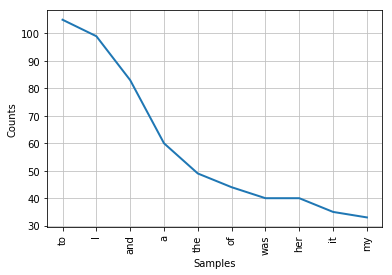

In [22]:
x_text.plot(10) ## most_common 10개 count

#### x_list를 dov2vec형태로 변환한다

In [23]:
from gensim.models.doc2vec import TaggedDocument

C:\Users\PARK SEONGRI\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


x_list와 y_list를 합쳐준다

In [24]:
list_combined = []

In [25]:
for i in range(len(x_list)):
    a = []
    a.append(x_list[i])
    a.append(y_list[i])
    list_combined.append(a)

In [57]:
list_combined[:10]

[[['I', 'try', 'and', 'avoid', 'this', 'sort', 'of', 'conflict'], 0],
 [['Had',
   'a',
   'friend',
   'open',
   'up',
   'to',
   'me',
   'about',
   'his',
   'mental',
   'addiction',
   'to',
   'weed',
   'and',
   'how',
   'it',
   'was',
   'taking',
   'over',
   'his',
   'life',
   'and',
   'making',
   'him',
   'depressed'],
  1],
 [['I',
   'saved',
   'a',
   'girl',
   'from',
   'suicide',
   'once',
   'She',
   'was',
   'going',
   'to',
   'swallow',
   'a',
   'bunch',
   'of',
   'pills',
   'and',
   'I',
   'talked',
   'her',
   'out',
   'of',
   'it',
   'in',
   'a',
   'very',
   'calm',
   'loving',
   'way'],
  1],
 [['i',
   'cant',
   'think',
   'of',
   'one',
   'really',
   'i',
   'think',
   'i',
   'may',
   'have',
   'indirectly'],
  0],
 [['Only',
   'really',
   'one',
   'friend',
   'who',
   'doesn',
   't',
   'fit',
   'into',
   'the',
   'any',
   'of',
   'the',
   'above',
   'categories',
   'Her',
   'therapist',
   'calls',
 

tagged list로 변환시킨다

In [27]:
tagged_docs = [TaggedDocument(d, [c]) for d,c in list_combined]

In [58]:
tagged_docs[:10]

[TaggedDocument(words=['I', 'try', 'and', 'avoid', 'this', 'sort', 'of', 'conflict'], tags=[0]),
 TaggedDocument(words=['Had', 'a', 'friend', 'open', 'up', 'to', 'me', 'about', 'his', 'mental', 'addiction', 'to', 'weed', 'and', 'how', 'it', 'was', 'taking', 'over', 'his', 'life', 'and', 'making', 'him', 'depressed'], tags=[1]),
 TaggedDocument(words=['I', 'saved', 'a', 'girl', 'from', 'suicide', 'once', 'She', 'was', 'going', 'to', 'swallow', 'a', 'bunch', 'of', 'pills', 'and', 'I', 'talked', 'her', 'out', 'of', 'it', 'in', 'a', 'very', 'calm', 'loving', 'way'], tags=[1]),
 TaggedDocument(words=['i', 'cant', 'think', 'of', 'one', 'really', 'i', 'think', 'i', 'may', 'have', 'indirectly'], tags=[0]),
 TaggedDocument(words=['Only', 'really', 'one', 'friend', 'who', 'doesn', 't', 'fit', 'into', 'the', 'any', 'of', 'the', 'above', 'categories', 'Her', 'therapist', 'calls', 'it', 'spiraling', 'Anyway', 'she', 'pretty', 'much', 'calls', 'me', 'any', 'time', 'she', 'is', 'frustrated', 'by', 's

train와 test data set을 나누어준다.

In [42]:
import random

In [46]:
tagged_train_docs = random.sample(tagged_docs, 70)
tagged_test_docs = random.sample(tagged_docs, 10)

In [47]:
from gensim.models import doc2vec

# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(size=725, alpha=0.025, min_alpha=0.025, seed=1234) # 725 = unique token 개수
doc_vectorizer.build_vocab(tagged_train_docs)

# logistic regression model 구축
train_x = np.array(doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs)
train_y = np.array(doc.tags[0] for doc in tagged_train_docs)

In [48]:
# doc_vectorizer train
for epoch in range(1000):
    doc_vectorizer.train(tagged_train_docs, total_examples=725, epochs = 10)
    doc_vectorizer.alpha -= 0.002
    doc_vectorizer.min_alpha = doc_vectorizer.alpha

In [49]:
# logistic regression model 구축
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]

test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]

In [50]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 4)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)

0.80000000000000004

쨘!

### Reference

- https://www.kaggle.com/samdeeplearning/deepnlp
- https://www.lucypark.kr/slides/2015-pyconkr/#13
- YBIGTA 2071년 여름교육 0729 정규표현식 강의